# Vehicle Routing Problem (VRP)

Author: Enricco Gemha

*This project targets the architecture of MacOS, which I'm running. Please, tweak the `compile_commands` below for the specifics of your OS.*

In [1]:
# Compile the C++ programs
compile_commands = [
  "cd src/implementations",
  "g++ -std=c++11 -o global_search global_search.cpp utils.cpp",
  "g++ -std=c++11 -o nearest_neighbor nearest_neighbor.cpp utils.cpp",
  "/opt/homebrew/opt/llvm/bin/clang++ -fopenmp -std=c++11 -I/opt/homebrew/opt/libomp/include -L/opt/homebrew/opt/libomp/lib -o omp omp.cpp utils.cpp"
]

## Objective

Develop a C++ application to optimize vehicle routes for a logistics company, aiming to minimize the total cost of routes.

## Description

You are tasked with creating a computational solution for the Vehicle Routing Problem (VRP) for a logistics company. The company has a fleet of vehicles used to deliver products to various clients. Each vehicle has a maximum load capacity, and each client has a specific demand that must be met. The goal is to determine the optimal routes for the vehicles, ensuring that all clients are served, vehicle capacity constraints are respected, and the total delivery cost is minimized.

## Constraints and Requirements


- **Vehicle Capacity**: Each vehicle has a maximum load capacity that cannot be exceeded.

- **Client Demand**: Each client has a specific demand that must be fully met by a single vehicle.

- **Route Cost**: Each route has a cost representing the aggregate computation of distance traveled, delivery time, and fuel consumption. The objective is to minimize the total cost.

- **Maximum Visits per Route**: Each route can visit a maximum number of cities.

- **Start and End Point**: All vehicles start and end their routes at the company's depot.

## Computational Challenges

- VRP is an NP-hard problem, meaning its computational complexity grows exponentially with the number of clients and vehicles.

- Exhaustive search for all possible route combinations becomes impractical for larger instances of the problem.

## Solution Composition

1. **Global Search Algorithm**: Implementation of a brute-force algorithm for the problem.

2. **Heuristic Solution**: Implementation of an approximate solution using heuristics or local search methods.

3. **Parallelization with OpenMP**: Utilize threads and the OpenMP library to parallelize the developed algorithm to reduce execution time. This involves analyzing and implementing the parallelization of components that can benefit from concurrent execution, such as initial solution generation or local search.

### Why choosing them?

### 1. Global Search (Vanilla)

Also known as exhaustive search, is chosen for its ability to find the exact optimal solution by evaluating all possible permutations of routes. Despite its computational intensity, global search serves as an essential baseline for the following reasons:

- **Optimal Solution**: It guarantees finding the optimal solution by exhaustively exploring all possible routes.

- **Benchmarking**: Provides a benchmark to compare the effectiveness and efficiency of heuristic and parallel approaches.

- **Comprehensive Analysis**: Useful for understanding the problem's solution space and for small to medium-sized instances where computational resources allow for exhaustive evaluation.

### 2. Nearest Neighbor (Heuristic)

While it does not guarantee an optimal solution, it usually provides a good approximation in a much shorter runtime compared to evaluating all permutations. Some of its benefits are:

- **Efficiency**: It significantly reduces the computational complexity by avoiding the factorial growth associated with generating all permutations.

- **Simplicity**: The heuristic is straightforward to implement and understand.

- **Performance**: It often yields a reasonably good solution quickly, making it suitable for large problem instances where an exact solution is computationally infeasible.

### 3. OpenMP paralellization (Fancy)

To improve the performance using OpenMP, we can parallelize the for loops where independent iterations can be executed concurrently, specially on the following parts:

- **Generating Permutations**: This part is inherently sequential due to the nature of permutations generation, so it doesn't benefit from parallelization.

- **Valid Routes Calculation**: We can parallelize the outer loop that iterates over all routes to determine valid routes.

- **Finding the Best Route**: We can parallelize the outer loop that iterates over valid routes to find the one with the minimum cost.

This way, the performance can be improved when number of routes (permutations) is large.

In [2]:
import random
import os
import time
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Input Generation for Testing

To effectively test the Vehicle Routing Problem (VRP) solution, it is essential to generate diverse and realistic input data. This section outlines the process for creating input files representing various graph configurations and client demands.

### Functions for Input Generation

We use two primary functions to generate the input data:

1. `gerar_dicionario_demandas(N)`: This function creates a dictionary where each key is an integer from 1 to N (representing clients), and the value is a random integer between 1 and 10, representing the demand of each client.

2. `gerar_entradas_grafo(num_nos, max_peso=100, probabilidade=0.25)`: This function generates a graph representing the VRP scenario. The graph includes nodes (clients and the depot) and weighted edges (representing the cost between nodes). The function ensures that each node is connected to the depot and randomly creates connections between other nodes based on a given probability.

### Usage Example

The following code will use these functions to generate input files for graphs with varying sizes (from 5 to 15 nodes). Each generated file includes:

- The total number of nodes (including the depot).

- The demand of each client.

- The edges between nodes with their associated costs.

In [3]:
def gerar_dicionario_demandas(N):
  """
  Gera um dicionário onde a chave é um int de 1 até N e o valor é um inteiro aleatório de 1 até 10.

  :param N: Número máximo para as chaves do dicionário.
  :return: Dicionário com chaves de 1 até N e valores inteiros aleatórios de 1 até 10.
  """
  return {i: random.randint(1, 10) for i in range(1, N)}


def gerar_entradas_grafo(num_nos, max_peso=100, probabilidade=0.25):
  """
  Gera um grafo para o problema de otimização de rotas de veículos.

  :param num_nos: Número de nós no grafo, incluindo o depósito.
  :param max_peso: Peso máximo para as arestas do grafo.
  :param probabilidade: Probabilidade de criar uma rota entre duas cidades.
  :return: Um dicionário representando o grafo onde as chaves são tuplas representando as arestas (nó1, nó2)
            e os valores são os pesos dessas arestas.
  """
  grafo = {}
  # Gerar pesos para arestas entre o depósito e outros nós
  for i in range(1, num_nos):
    grafo[(0, i)] = random.randint(1, max_peso)
    grafo[(i, 0)] = grafo[(0, i)]  # Assume que a distância de volta ao depósito é a mesma

  # Gerar pesos para arestas entre todos os outros pares de nós
  for i in range(1, num_nos+1):
    for j in range(i+1, num_nos):
      if random.random() > (1 - probabilidade):  # Verifica a probabilidade
        peso = random.randint(1, max_peso)
        grafo[(i, j)] = peso

  return grafo

############################################
#             Exemplo de uso
############################################
for num_nos in range(5, 16): # Número total de nós incluindo o depósito
  demandas = gerar_dicionario_demandas(num_nos)  # Gera as demandas para cada nó
  grafo = gerar_entradas_grafo(num_nos)          # Gera o grafo que representa os locais e custos entre eles

  # Salva o grafo em um arquivo TXT
  with open(f'src/input/graph{f"0{num_nos}" if len(str(num_nos)) == 1 else num_nos}.txt', 'w') as arquivo:
    arquivo.write(str(num_nos) + "\n")    # Número de nós, incluindo depósito
    for local, demanda in demandas.items():
      linha = f"{local} {demanda}\n"      # Par LOCAL DEMANDA
      arquivo.write(linha)

    arquivo.write(str(len(grafo)) + "\n") # Número de arestas
    for aresta, peso in grafo.items():
      linha = f"{aresta[0]} {aresta[1]} {peso}\n" # Trio: ORIGEM DESTINO CUSTO
      arquivo.write(linha)


## Compilation of C++ Programs

To ensure all C++ programs are correctly compiled before execution, we run the compile commands in a single shell session. This approach guarantees that any dependencies between commands are respected.

In [4]:
# Concatenate the commands with '&&'
compile_command_string = " && ".join(compile_commands)
# Run the compile command
compile_process = subprocess.Popen(compile_command_string, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
# Get the output and error
compile_stdout, compile_stderr = compile_process.communicate()

# Print the compile output and error
print("Compile Output:\n", compile_stdout.decode())
print("Compile Error:\n", compile_stderr.decode())

Compile Output:
 
Compile Error:
 ld: warning: reexported library with install name '/opt/homebrew/opt/llvm/lib/libunwind.1.dylib' found at '/opt/homebrew/Cellar/llvm/18.1.6/lib/libunwind.1.0.dylib' couldn't be matched with any parent library and will be linked directly



## Execution and Timing of C++ Programs

Now, we must create a function to run the executable and get its runtime.

And then, to measure the performance of the compiled C++ programs, we run each executable against a series of input files and record the execution times.

In [5]:
# Define the capacity and input file folder
capacity = 15
input_folder = os.path.join(os.getcwd(), "src/input")

In [6]:
def run_and_time_executable(executable_name):
  results = {}
  for file in os.listdir(input_folder):
    if file.startswith("graph") and file.endswith(".txt"):
      # Extract the graph number from the file name
      graph_number = int(file[5:-4])
      start = time.time()
      # Call the executable with the input file
      process = subprocess.Popen(f"./{executable_name} {os.path.join(input_folder, file)} {capacity}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
      stdout, stderr = process.communicate()
      end = time.time()
      results[graph_number] = end - start
  return results

### Global Search runtime plot

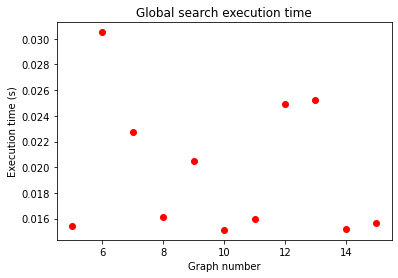

In [7]:
# Run the global search executable and plot the results
global_results = run_and_time_executable("global_search")
plt.plot(list(global_results.keys()), list(global_results.values()), "ro")
plt.xlabel("Graph number")
plt.ylabel("Execution time (s)")
plt.title("Global search execution time")
plt.show()

### Heuristic (Nearest Neighbor) runtime plot

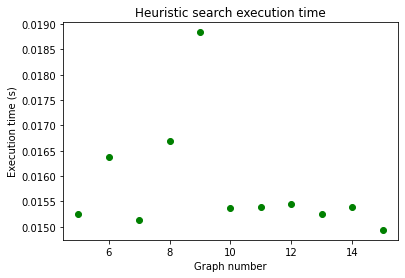

In [8]:
# Run the heuristic search executable and plot the results
heuristic_results = run_and_time_executable("nearest_neighbor")
plt.plot(list(heuristic_results.keys()), list(heuristic_results.values()), "go")
plt.xlabel("Graph number")
plt.ylabel("Execution time (s)")
plt.title("Heuristic search execution time")
plt.show()

### Parallel (OpenMP) runtime plot

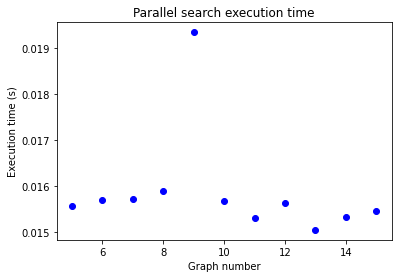

In [9]:
# Run the parallel search executable and plot the results
parallel_results = run_and_time_executable("omp")
plt.plot(list(parallel_results.keys()), list(parallel_results.values()), "bo")
plt.xlabel("Graph number")
plt.ylabel("Execution time (s)")
plt.title("Parallel search execution time")
plt.show()

## Execution Time Comparison

To evaluate the performance of different vehicle routing problem (VRP) solution approaches, we compare the execution times of the aforementioned methods.

### Why Use a Logarithmic Scale?

A logarithmic scale is used to facilitate the comparison of execution times across a wide range of values. The main reasons for choosing a logarithmic scale are:

- **Wide Range of Values**: Execution times can vary significantly, especially between exhaustive search and heuristic or parallel methods. A logarithmic scale compresses large values and expands smaller values, making it easier to compare methods with vastly different execution times.

- **Better Visualization of Differences**: In a regular (linear) scale, large values can dominate the plot, making it difficult to discern differences among smaller values. A logarithmic scale provides a clearer view of the relative differences between methods.

- **Exponential Growth**: Since VRP is an NP-hard problem, execution times can grow exponentially with the number of nodes. A logarithmic scale is particularly effective in illustrating exponential growth patterns.

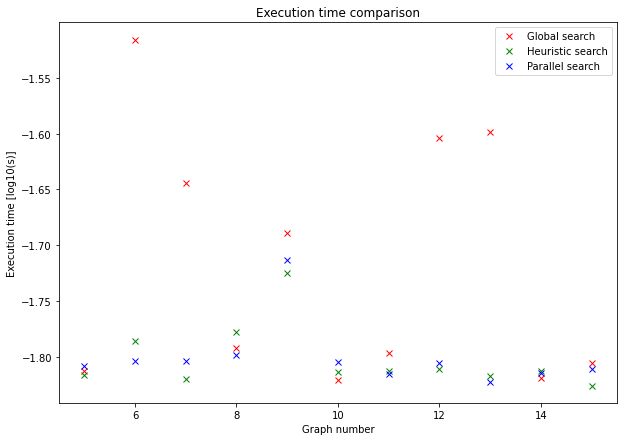

In [10]:
# Compare the time taken for all the methods
plt.figure(figsize=(10, 7))
plt.plot(
    list(global_results.keys()),
    np.log10(list(global_results.values())),
    "rx",
    label="Global search",
)
plt.plot(
    list(heuristic_results.keys()),
    np.log10(list(heuristic_results.values())),
    "gx",
    label="Heuristic search",
)
plt.plot(
    list(parallel_results.keys()),
    np.log10(list(parallel_results.values())),
    "bx",
    label="Parallel search",
)
plt.xlabel("Graph number")
plt.ylabel("Execution time [log10(s)]")
plt.title("Execution time comparison")
plt.legend()
plt.show()

## Evaluating Results

The results are presented in the form of a scatter plot. Each data point represents the execution time for a specific graph size using one of the three approaches. The x-axis denotes the graph number (indicative of its size), while the y-axis represents the execution time in logarithmic scale.

### Expected Results

1. **Parallel Search vs. Sequential (Global) Search**:

    - Expectation: The parallel search approach should be faster than the global search due to the concurrent execution of independent tasks.
    
    - Observation: The data points for the Parallel Search approach are generally lower than those for the Global Search, indicating that parallelization has effectively reduced execution times.

2. **Heuristic Search vs. Exhaustive (Global) Search**:

    - Expectation: The heuristic search should be faster than the exhaustive global search as it seeks approximate solutions without exploring all possibilities.
    
    - Observation: The heuristic search consistently shows lower execution times compared to the global search, confirming that the heuristic method is more efficient.

## Anomalies and Potential Causes

While the results generally align with expectations, demonstrating the effectiveness of heuristic and parallel approaches in reducing execution times for larger graph sizes, there are instances where:

- The Parallel Search approach does not significantly outperform the Sequential Search.

- The Heuristic Search approach's performance is closer to the Global Search than expected.

These anomalies could be due to several factors:

- **Overhead of Parallelization**: For smaller graph sizes, the overhead associated with managing multiple threads could outweigh the benefits of parallel execution, leading to comparable or slightly higher execution times for the parallel approach.

- **Implementation Specifics**: The efficiency of the implemented heuristic and parallel algorithms may also influence the results. Optimizations in code are potential in leading to more pronounced differences.

_This project development was aided by generative artificial intelligence, such as GitHub Copilot and ChatGPT._